# カルマンフィルタを実装したい

In [1]:
# URL:https://pykalman.github.io/
# URL:https://qiita.com/acela86/items/fdafb10ce5e2e0d73c9e


# カルマンフィルタとは
"""
カルマンフィルタは、複数の不確実な情報を用いて，より正確な情報を推定する事ができる！
カルマンフィルタはodometryとobservationの2つの値を合成して状態を推定するが
この2つの値のうち、どちらをどれだけ重要視するかをカルマンゲインというパラメータを使ってコントロールしています。
※予測と更新という2つのステップを繰り返すことで、ある時点までに得られた誤差を含む情報をもとに、「現在の状態を予測する」アルゴリズム
※時間軸に対する順方向の推定
●調査結果
・pykalmanで簡単に実装可能だけどライブラリでの処理が遅い
・
"""

# カルマンスムーサー
"""
カルマンフィルターの拡張
カルマンスムーザーは、カルマンフィルターで得られた予測結果を「遡って修正する」ことができるアルゴリズム
※解析するデータが出そろった時点で推定する必要がある為、オンライン・リアルタイムには向かない
※時間軸に対する逆方向の推定

"""


'\nカルマンフィルターの拡張\nカルマンスムーザーは、カルマンフィルターで得られた予測結果を「遡って修正する」ことができるアルゴリズム\n※解析するデータが出そろった時点で推定する必要がある為、オンライン・リアルタイムには向かない\n※時間軸に対する逆方向の推定\n\n'

# 持続予測モデル + 自動FFTバンドパスフィルタ

In [3]:
import os
import sys
import time
import math
from random import randint

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
#from pykalman import KalmanFilter


In [6]:
eps = np.finfo(float).eps

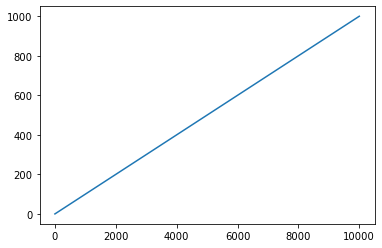

In [86]:
#試しに確認する
data_ = np.arange(0, 1000, 0.1)
plt.plot(data_)

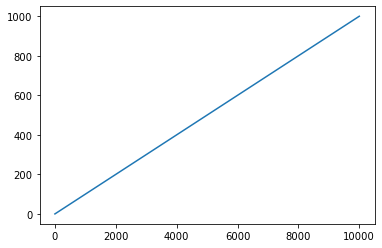

In [85]:
data_2 = f()

In [50]:
f([10, 10])

array([-99.,   0.])

In [51]:
## 連続非線形モデル
def f(x, r = 0.2):
    n = x[0]
    L = x[1]

    dx = np.zeros(2)
    
    # 初期値の演算だと
    # 0.1*0.01 - 0.1*0.01*0.01*0.01
    dx[0] = r * n - r * n * n * L

    return dx

In [63]:
## 離散線形モデル
def A(x, r = 0.2):
    n = x[0]
    L = x[1]

    A = np.zeros([2, 2])
    
    # 初期値だと
    # 0.1 - 2 * 0.01 * 0.01 * 0.01
    A[0, 0] = r - 2 * n * r * L
    # 0.1 - 2 * 0.01 * 0.01 * 0.01
    A[0, 1] = - r * n * n

    return A

In [64]:
## 初期化
T = 250                            # シミュレーション時間
dt = 0.01                            # 演算周期
meas_step = 1                       # 観測タイミング

nx = 2                              # 状態ベクトルの次元
ny = 1                              # 観測ベクトルの次元

Q = np.diag([0, 0])                 # プロセスノイズ行列：np.diagで対角行列を作っている
R = np.matrix([2])                  # 観測ノイズ行列
H = np.matrix([1, 0])               # 観測方程式（観測行列）


In [65]:
print(Q)
print(H)
print(R)

[[0 0]
 [0 0]]
[[1 0]]
[[2]]


In [88]:
## シミュレーション
t = np.arange(0, T, dt)             # 時刻ベクトル：対象の意系列データ： (0～T時刻まで、サンプリングレート:dt)
N = len(t)                          # 上記、対象時系列のサンプル数
print(N)
x = np.zeros([N, nx])               # 状態ベクトル（真値）：2次元
y = np.zeros([N, ny])               # 観測ベクトル（ノイズなし）：1次元
z = np.zeros([N, ny])               # 観測ベクトル（ノイズあり）：1次元

np.random.seed(1)
w = np.random.randn(N, nx)          # プロセスノイズ　→　これなにノイズだろう
v = np.random.randn(N, ny)          # 観測ノイズ

x[0,:] = np.array([0.0001, 0.05])   # 初期値

25000


In [89]:
# dotの使い方は、どっちでも内積計算できる
print(np.dot(np.diag([5, 5]), [1, 0]))
print()
print(np.diag([5, 5]).dot(0.01))

[5 0]

[[0.05 0.  ]
 [0.   0.05]]


In [90]:
x

array([[0.0001, 0.05  ],
       [0.    , 0.    ],
       [0.    , 0.    ],
       ...,
       [0.    , 0.    ],
       [0.    , 0.    ],
       [0.    , 0.    ]])

In [68]:
# 連続非線形モデルを作成している：自作関数：f
# x(状態ベクトル)　→　Q(プロセスノイズ)   [[0, 0][0, 0]]
# y(観測ベクトル)　→　H(観測ノイズ)       [[1, 0]]
# z(観測ベクトルnoise)　→　R(観測方程式)  [[2]]

for i in range(1, N):
    
    # xは、1時刻前のxの値 + モデル値を加算する (1時刻前x値をsr0.01に換算し、プロセスノイズ)
    # Qは成分が0で構成される対角行列の為、wのノイズ行列が0に初期化されている気がする、、なぜ、、
    # [0.0001 0.05] [0.0001001 0.05] [0.0001002 0.05 ]なかんじになる、、、
    # 連続非線形モデルを生成する
    x[i,:] = x[i-1,:] + f(x[i-1,:]).dot(dt) + Q.dot(w[i,:])
    
    # xから、1次成分の行列を取得しているのと同義：[1,0]とdot積を算出
    # [0.] [0.0001001] [0.0001002] なかんじ。
    y[i,:] = H.dot(x[i,:])
    
    # yに、観測ノイズvを2倍(Rとdot積)した値
    z[i,:] = y[i,:] + R.dot(v[i,:])

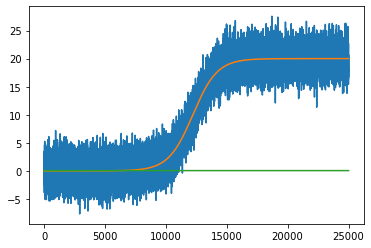

In [69]:
# 作成した非線形モデルの表示
plt.plot(z)
plt.plot(x)

In [70]:
eee = np.eye(5, 8, 3)
print(eee.shape)
print(eee)

(5, 8)
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [71]:
xu[-1,:]
#.dot(dt)

array([19.97834997,  0.05005404])

# カルマンフィルター

In [72]:
%%time


# 事前推定値の入れ物を作成（予測ステップの結果)
xp = np.zeros([N, nx])              
# 事前誤差共分散の入れ物を作成（予測ステップの結果）
Pp = np.zeros([N, nx, nx])          


# 初期推定値
xp[0,:] = np.array([0.01, 0.01])        
# 初期共分散
# ここはパラメータになるので、最適化代を調査する
Pp[0,:,:] = np.diag([0.1**2, 0.05**2])  


# 事後推定値（更新ステップの結果）
xu = np.copy(xp)
# 事後誤差共分散（更新ステップの結果）
Pu = np.copy(Pp)


Wall time: 1e+03 µs


In [73]:
%%time
# 1から最終時系列までを推測する(0は初期値が入る)
for i in range(1, N):
    
    # 予測ステップ
    # 1時刻前の事後推定値を連続非線形モデル関数にいれ、dtで内積を計算し、1時刻前の事後推定値に加算する
    xp[i,:] = xu[i-1,:] + f(xu[i-1,:]).dot(dt)
    
    # 離散線型モデルを作る
    # 単位行列(2)=[[1, 0][0, 1]] + A[[X, y][0 , 0]]の内積(dt演算周期0.01)※基本的にdtをかけるだけ
    F = np.eye(nx) + A(xu[i-1,:]).dot(dt)
    
    # Qはプロセスノイズ行列[[0,0][0,0]]
    Pp[i,:,:] = F.dot(Pu[i-1,:,:]).dot(F.T) + Q
    
    # 更新ステップ
    if i % meas_step == 0:
        e = z[i,:] - H.dot(xp[i,:])
        S = R + H.dot(Pp[i,:,:]).dot(H.T)
        K = Pp[i,:,:].dot(H.T).dot(np.linalg.inv(S))
        xu[i,:] = xp[i,:] + K.dot(e).squeeze()
        Pu[i,:,:] = (np.eye(nx) - K.dot(H)).dot(Pp[i,:,:])
    else:
        xu[i,:] = xp[i,:]
        Pu[i,:,:] = Pp[i,:,:]


Wall time: 1.62 s


In [74]:
%%time
## カルマンスムーザー
xs = np.zeros([N, nx])              # 推定値
Ps = np.zeros([N, nx, nx])          # 誤差共分散
xs[-1,:] = xu[-1,:]
Ps[-1,:,:] = Pu[-1,:,:]

for i in reversed(range(N-1)):
    # 平滑ステップ
    F = np.eye(nx) + A(xs[i+1,:]).dot(dt)
    C = Pu[i,:,:].dot(F.T).dot(np.linalg.inv(Pp[i+1,:,:]))

    xs[i,:] = xu[i,:] + C.dot(xs[i+1,:] - xp[i+1,:]).squeeze()
    Ps[i,:,:] = Pu[i,:,:] + C.dot(Ps[i+1,:,:] - Pp[i+1,:,:]).dot(C.T)

<ipython-input-63-63e6050d94de>:10: RuntimeWarning: overflow encountered in double_scalars
  A[0, 0] = r - 2 * n * r * L
<ipython-input-63-63e6050d94de>:12: RuntimeWarning: overflow encountered in double_scalars
  A[0, 1] = - r * n * n


Wall time: 594 ms


In [75]:
## 誤差共分散から標準偏差σを計算
pdf = np.zeros([N, nx])
pds = np.zeros([N, nx])

for i in range(nx):
    pdf[:,i] = np.sqrt(np.maximum(Pu[:,i,i], eps))
    pds[:,i] = np.sqrt(np.maximum(Ps[:,i,i], eps))

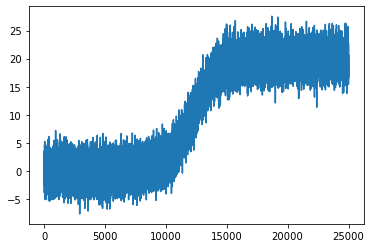

In [76]:
z.shape
plt.plot(z)

In [77]:
## プロット
plt.close('all')

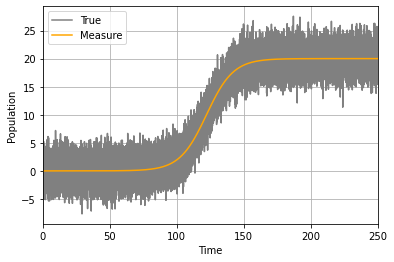

In [78]:
# 観測値
plt.figure()
plt.plot(t, z[:,0], 'grey', t, x[:,0], 'orange')
plt.grid()
plt.xlim([0,T])
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend(['True', 'Measure'], loc='upper left')

Text(0, 0.5, '$L(=1/K)$')

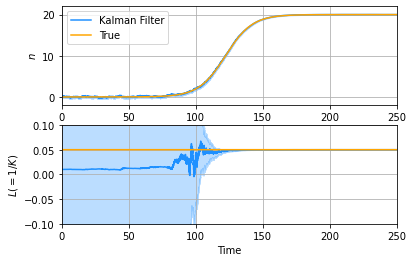

In [79]:
# カルマンフィルターの演算結果
plt.figure()
plt.subplot(2,1,1)
plt.fill_between(t, xp[:,0] - pdf[:,0] * 3, xp[:,0] + pdf[:,0] * 3, alpha = 0.3, color = 'dodgerblue')
plt.plot(t, xp[:,0], 'dodgerblue', t, x[:,0], 'orange')
plt.grid()
plt.xlim([0,T])
plt.ylim([-2,22])
plt.ylabel('$n$')
plt.legend(['Kalman Filter', 'True'], loc='upper left')

plt.subplot(2,1,2)
plt.fill_between(t, xp[:,1] - pdf[:,1] * 3, xp[:,1] + pdf[:,1] * 3, alpha = 0.3, color = 'dodgerblue')
plt.plot(t, xp[:,1], 'dodgerblue', t, x[:,1], 'orange')
plt.grid()
plt.xlim([0,T])
plt.ylim([-0.1, 0.1])
plt.xlabel('Time')
plt.ylabel('$L(=1/K)$')

Text(0, 0.5, '$L(=1/K)$')

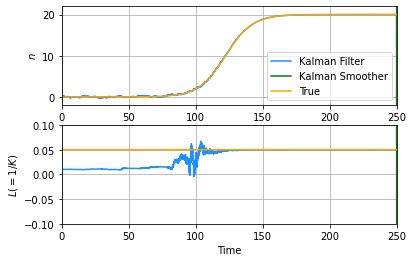

In [80]:
# カルマンスムーザーの演算結果
plt.figure()
plt.subplot(2,1,1)
plt.fill_between(t, xs[:,0] - pds[:,0] * 3, xs[:,0] + pds[:,0] * 3, alpha = 0.3, color = 'green')
plt.plot(t, xp[:,0], 'dodgerblue', t, xs[:,0], 'green', t, x[:,0], 'orange')
plt.grid()
plt.xlim([0,T])
plt.ylim([-2,22])
plt.ylabel('$n$')
plt.legend(['Kalman Filter', 'Kalman Smoother', 'True'], loc='lower right')

plt.subplot(2,1,2)
plt.fill_between(t, xs[:,1] - pds[:,1] * 3, xs[:,1] + pds[:,1] * 3, alpha = 0.3, color = 'green')
plt.plot(t, xp[:,1], 'dodgerblue', t, xs[:,1], 'green', t, x[:,1], 'orange')
plt.grid()
plt.xlim([0,T])
plt.ylim([-0.1, 0.1])
plt.xlabel('Time')
plt.ylabel('$L(=1/K)$')

Text(0, 0.5, '$L(=1/K)$')

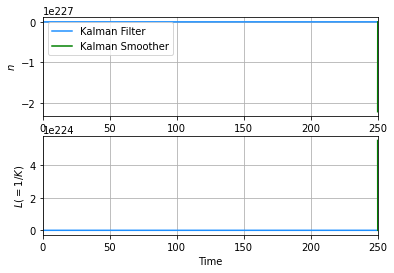

In [81]:
# 誤差
plt.figure()
plt.subplot(2,1,1)
plt.plot(t, xp[:,0] - x[:,0], 'dodgerblue', t, xs[:,0] - x[:,0], 'green')
plt.grid()
plt.xlim([0,T])
plt.ylabel('$n$')
plt.legend(['Kalman Filter', 'Kalman Smoother'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(t, xp[:,1] - x[:,1], 'dodgerblue', t, xs[:,1] - x[:,1], 'green')
plt.grid()
plt.xlim([0,T])
plt.xlabel('Time')
plt.ylabel('$L(=1/K)$')